# Stocks Price Prediction

In [285]:
import pandas as pd
import yfinance as yf
import numpy as np
from datetime import datetime
import os
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import tensorflow as tf


2025-09-11 10:40:14.627404: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [227]:
# function to download and save the raw data
def get_data(ticker, start, end):
    raw_data = yf.download(ticker, start, end)
    os.makedirs(f"../datasets/{ticker}", exist_ok=True)
    raw_data.to_csv(f"../datasets/{ticker}/raw.csv")
    return raw_data

In [228]:
ticker = "GOOG"
end = datetime.now()
start = datetime(end.year - 10, end.month, end.day)
print(start)

2015-09-11 00:00:00


In [229]:
# downloading the data
raw_data = get_data(ticker, start, end)
raw_data.head()

/tmp/ipykernel_8497/1084484216.py:3: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,GOOG,GOOG,GOOG,GOOG,GOOG
Date,,,,,
2015-09-11,31.075838,31.076334,30.661176,30.776883,27470000
2015-09-14,30.950197,31.080305,30.760992,31.072360,34046000
2015-09-15,31.541157,31.717946,30.977017,31.122024,41688000
2015-09-16,31.582870,31.680700,31.401114,31.557544,25730000
2015-09-17,31.926516,32.323795,31.535193,31.672751,45494000


In [230]:
# quick clean up
def clean_up(data):
    clean_data = data.copy()
    clean_data.columns = clean_data.columns.get_level_values(0)
    clean_data.columns.name = None
    clean_data.to_csv(f"../datasets/{ticker}/clean.csv")

clean_up(raw_data)

In [231]:
data = pd.read_csv(f"../datasets/{ticker}/clean.csv")
data.head(10)

,Date,Close,High,Low,Open,Volume
0,2015-09-11,31.075838,31.076334,30.661176,30.776883,27470000
1,2015-09-14,30.950197,31.080305,30.760992,31.072360,34046000
2,2015-09-15,31.541157,31.717946,30.977017,31.122024,41688000
3,2015-09-16,31.582870,31.680700,31.401114,31.557544,25730000
4,2015-09-17,31.926516,32.323795,31.535193,31.672751,45494000
5,2015-09-18,31.248657,31.782504,31.137915,31.623096,102668000
6,2015-09-21,31.556055,31.608198,31.084285,31.504408,35770000
7,2015-09-22,30.922888,31.164236,30.562354,31.136923,51258000
8,2015-09-23,30.906498,31.232766,30.789300,30.891104,29418000
9,2015-09-24,31.077330,31.152811,30.411883,30.622442,44802000


In [232]:
data.shape

(2514, 6)

In [233]:
data.isnull().sum()

Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

In [234]:
data.duplicated().sum()

np.int64(0)

In [235]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2514 entries, 0 to 2513
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2514 non-null   object 
 1   Close   2514 non-null   float64
 2   High    2514 non-null   float64
 3   Low     2514 non-null   float64
 4   Open    2514 non-null   float64
 5   Volume  2514 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 118.0+ KB


In [236]:
data.tail(10)

,Date,Close,High,Low,Open,Volume
2504,2025-08-27,208.024078,209.382865,206.205696,206.275641,15249000
2505,2025-08-28,212.180344,212.709869,207.414614,207.654390,20915700
2506,2025-08-29,213.339310,215.147691,210.781598,211.081333,24682200
2507,2025-09-02,211.800705,212.179364,206.775198,208.803384,28900100
2508,2025-09-03,230.893631,231.593003,224.918960,226.277746,72250300
2509,2025-09-04,232.452240,232.562142,226.557499,229.949472,32196000
2510,2025-09-05,234.959991,235.919141,232.172490,232.452238,26127700
2511,2025-09-08,234.160004,238.399994,233.729996,235.789993,23128800
2512,2025-09-09,239.940002,240.589996,233.380005,234.190002,22854800
2513,2025-09-10,239.559998,242.080002,238.110001,239.250000,19972500


In [237]:
data.describe()

,Close,High,Low,Open,Volume
count,2514.000000,2514.000000,2514.000000,2514.000000,2.514000e+03
mean,92.787570,93.747445,91.784196,92.721317,2.955410e+07
std,48.369558,48.906652,47.812818,48.325833,1.417230e+07
min,29.542334,30.044399,29.268707,29.661023,6.809800e+06
25%,52.080349,52.716499,51.407703,52.128768,2.064800e+07
50%,75.902832,77.580845,75.230922,75.811949,2.612885e+07
75%,133.606316,135.052052,132.041907,133.527482,3.408300e+07
max,239.940002,242.080002,238.110001,239.250000,1.330780e+08


In [238]:
data["Date"] = pd.to_datetime(data["Date"])
data.head(10)

,Date,Close,High,Low,Open,Volume
0,2015-09-11,31.075838,31.076334,30.661176,30.776883,27470000
1,2015-09-14,30.950197,31.080305,30.760992,31.072360,34046000
2,2015-09-15,31.541157,31.717946,30.977017,31.122024,41688000
3,2015-09-16,31.582870,31.680700,31.401114,31.557544,25730000
4,2015-09-17,31.926516,32.323795,31.535193,31.672751,45494000
5,2015-09-18,31.248657,31.782504,31.137915,31.623096,102668000
6,2015-09-21,31.556055,31.608198,31.084285,31.504408,35770000
7,2015-09-22,30.922888,31.164236,30.562354,31.136923,51258000
8,2015-09-23,30.906498,31.232766,30.789300,30.891104,29418000
9,2015-09-24,31.077330,31.152811,30.411883,30.622442,44802000


In [239]:
# creating subplots
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=True,
    row_heights=[0.7, 0.3],
    vertical_spacing=0.2
)

# candle stick chart
fig.add_trace(go.Candlestick(
    x = data["Date"],
    open = data["Open"],
    high = data["High"],
    low = data["Low"],
    close = data["Close"],
    name = "Price"
    ),
    row=1, col=1
)

# volume bars
fig.add_trace(go.Bar(
    x = data["Date"],
    y = data["Volume"],
    name = "volume",
    marker_color="#c1440e",
    opacity=1.0,
    ),
    row=2, col=1
)

# layout
fig.update_layout(
    title = "Candlesticks Chart With Volume",
    xaxis_rangeslider_visible = False,
    xaxis_title="Date",
    yaxis_title="Price",
    yaxis2_title="Volume",
    template="plotly_dark",
    showlegend = False,
    height=900
)

fig.show()

In [240]:
# adding log returns and pct returns
data["Log_Returns"] = np.log(data["Close"] / data["Close"].shift(1))
data['Pct_Returns'] = data['Close'].pct_change()
data.head(10)

,Date,Close,High,Low,Open,Volume,Log_Returns,Pct_Returns
0,2015-09-11,31.075838,31.076334,30.661176,30.776883,27470000,NaN,NaN
1,2015-09-14,30.950197,31.080305,30.760992,31.072360,34046000,-0.004051,-0.004043
2,2015-09-15,31.541157,31.717946,30.977017,31.122024,41688000,0.018914,0.019094
3,2015-09-16,31.582870,31.680700,31.401114,31.557544,25730000,0.001322,0.001323
4,2015-09-17,31.926516,32.323795,31.535193,31.672751,45494000,0.010822,0.010881
5,2015-09-18,31.248657,31.782504,31.137915,31.623096,102668000,-0.021460,-0.021232
6,2015-09-21,31.556055,31.608198,31.084285,31.504408,35770000,0.009789,0.009837
7,2015-09-22,30.922888,31.164236,30.562354,31.136923,51258000,-0.020269,-0.020065
8,2015-09-23,30.906498,31.232766,30.789300,30.891104,29418000,-0.000530,-0.000530
9,2015-09-24,31.077330,31.152811,30.411883,30.622442,44802000,0.005512,0.005527


In [241]:
data.isnull().sum()

Date           0
Close          0
High           0
Low            0
Open           0
Volume         0
Log_Returns    1
Pct_Returns    1
dtype: int64

In [242]:
data.shape

(2514, 8)

In [243]:
data.head()

,Date,Close,High,Low,Open,Volume,Log_Returns,Pct_Returns
0,2015-09-11,31.075838,31.076334,30.661176,30.776883,27470000,NaN,NaN
1,2015-09-14,30.950197,31.080305,30.760992,31.072360,34046000,-0.004051,-0.004043
2,2015-09-15,31.541157,31.717946,30.977017,31.122024,41688000,0.018914,0.019094
3,2015-09-16,31.582870,31.680700,31.401114,31.557544,25730000,0.001322,0.001323
4,2015-09-17,31.926516,32.323795,31.535193,31.672751,45494000,0.010822,0.010881


In [244]:
data = data.dropna()
data.head(10)

,Date,Close,High,Low,Open,Volume,Log_Returns,Pct_Returns
1,2015-09-14,30.950197,31.080305,30.760992,31.072360,34046000,-0.004051,-0.004043
2,2015-09-15,31.541157,31.717946,30.977017,31.122024,41688000,0.018914,0.019094
3,2015-09-16,31.582870,31.680700,31.401114,31.557544,25730000,0.001322,0.001323
4,2015-09-17,31.926516,32.323795,31.535193,31.672751,45494000,0.010822,0.010881
5,2015-09-18,31.248657,31.782504,31.137915,31.623096,102668000,-0.021460,-0.021232
6,2015-09-21,31.556055,31.608198,31.084285,31.504408,35770000,0.009789,0.009837
7,2015-09-22,30.922888,31.164236,30.562354,31.136923,51258000,-0.020269,-0.020065
8,2015-09-23,30.906498,31.232766,30.789300,30.891104,29418000,-0.000530,-0.000530
9,2015-09-24,31.077330,31.152811,30.411883,30.622442,44802000,0.005512,0.005527
10,2015-09-25,30.390530,31.274482,30.342359,31.274482,43480000,-0.022348,-0.022100


In [245]:
data.shape

(2513, 8)

In [246]:
stats = data["Log_Returns"].describe()
skewness = data["Log_Returns"].skew()
kurtosis = data["Log_Returns"].kurtosis()

In [247]:

print("Summary Stats:\n", stats)
print("\nSkewness:", skewness)
print("Kurtosis:", kurtosis)

Summary Stats:
 count    2513.000000
mean        0.000813
std         0.018056
min        -0.117667
25%        -0.007176
50%         0.001363
75%         0.010058
max         0.099380
Name: Log_Returns, dtype: float64

Skewness: -0.18698246269582366
Kurtosis: 4.7606705125503765


In [248]:
# stationarity check
result = adfuller(data['Log_Returns'].dropna())
print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Value {key}: {value}')

ADF Statistic: -16.887097334459202
p-value: 1.0520320906287215e-29
Critical Value 1%: -3.4329642237790847
Critical Value 5%: -2.862694950990622
Critical Value 10%: -2.5673848250020415


In [249]:
# volatility visualization
window = 21
data['Rolling_Vol'] = data['Log_Returns'].rolling(window).std()
data.head(10)

,Date,Close,High,Low,Open,Volume,Log_Returns,Pct_Returns,Rolling_Vol
1,2015-09-14,30.950197,31.080305,30.760992,31.072360,34046000,-0.004051,-0.004043,NaN
2,2015-09-15,31.541157,31.717946,30.977017,31.122024,41688000,0.018914,0.019094,NaN
3,2015-09-16,31.582870,31.680700,31.401114,31.557544,25730000,0.001322,0.001323,NaN
4,2015-09-17,31.926516,32.323795,31.535193,31.672751,45494000,0.010822,0.010881,NaN
5,2015-09-18,31.248657,31.782504,31.137915,31.623096,102668000,-0.021460,-0.021232,NaN
6,2015-09-21,31.556055,31.608198,31.084285,31.504408,35770000,0.009789,0.009837,NaN
7,2015-09-22,30.922888,31.164236,30.562354,31.136923,51258000,-0.020269,-0.020065,NaN
8,2015-09-23,30.906498,31.232766,30.789300,30.891104,29418000,-0.000530,-0.000530,NaN
9,2015-09-24,31.077330,31.152811,30.411883,30.622442,44802000,0.005512,0.005527,NaN
10,2015-09-25,30.390530,31.274482,30.342359,31.274482,43480000,-0.022348,-0.022100,NaN


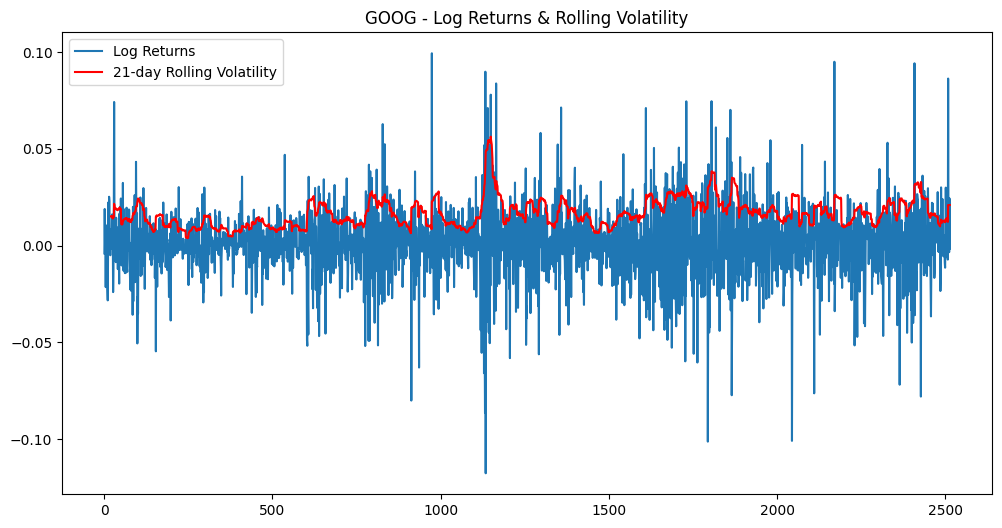

In [250]:
plt.figure(figsize=(12,6))
plt.plot(data['Log_Returns'], label='Log Returns')
plt.plot(data['Rolling_Vol'], label=f'{window}-day Rolling Volatility', color='red')
plt.legend()
plt.title(f"{ticker} - Log Returns & Rolling Volatility")
plt.show()

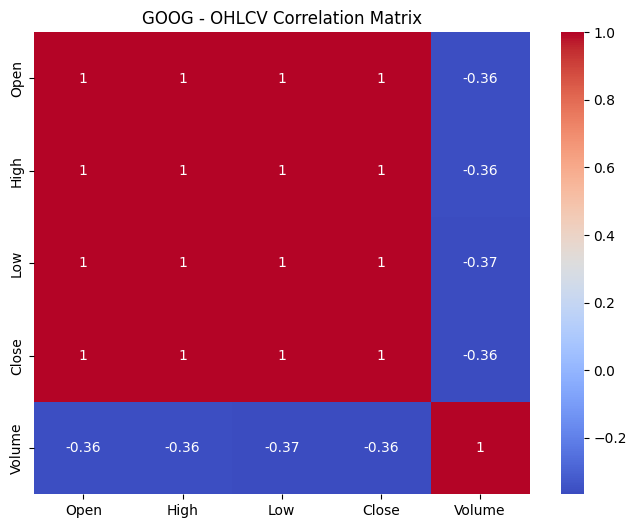

In [251]:
# correlation analysis
plt.figure(figsize=(8,6))
sns.heatmap(data[['Open','High','Low','Close','Volume']].corr(), annot=True, cmap='coolwarm')
plt.title(f"{ticker} - OHLCV Correlation Matrix")
plt.show()

In [252]:
data.head(10)

,Date,Close,High,Low,Open,Volume,Log_Returns,Pct_Returns,Rolling_Vol
1,2015-09-14,30.950197,31.080305,30.760992,31.072360,34046000,-0.004051,-0.004043,NaN
2,2015-09-15,31.541157,31.717946,30.977017,31.122024,41688000,0.018914,0.019094,NaN
3,2015-09-16,31.582870,31.680700,31.401114,31.557544,25730000,0.001322,0.001323,NaN
4,2015-09-17,31.926516,32.323795,31.535193,31.672751,45494000,0.010822,0.010881,NaN
5,2015-09-18,31.248657,31.782504,31.137915,31.623096,102668000,-0.021460,-0.021232,NaN
6,2015-09-21,31.556055,31.608198,31.084285,31.504408,35770000,0.009789,0.009837,NaN
7,2015-09-22,30.922888,31.164236,30.562354,31.136923,51258000,-0.020269,-0.020065,NaN
8,2015-09-23,30.906498,31.232766,30.789300,30.891104,29418000,-0.000530,-0.000530,NaN
9,2015-09-24,31.077330,31.152811,30.411883,30.622442,44802000,0.005512,0.005527,NaN
10,2015-09-25,30.390530,31.274482,30.342359,31.274482,43480000,-0.022348,-0.022100,NaN


In [253]:
data = data.drop("Rolling_Vol", axis=1)
data.head()

,Date,Close,High,Low,Open,Volume,Log_Returns,Pct_Returns
1,2015-09-14,30.950197,31.080305,30.760992,31.072360,34046000,-0.004051,-0.004043
2,2015-09-15,31.541157,31.717946,30.977017,31.122024,41688000,0.018914,0.019094
3,2015-09-16,31.582870,31.680700,31.401114,31.557544,25730000,0.001322,0.001323
4,2015-09-17,31.926516,32.323795,31.535193,31.672751,45494000,0.010822,0.010881
5,2015-09-18,31.248657,31.782504,31.137915,31.623096,102668000,-0.021460,-0.021232


In [254]:
data.shape

(2513, 8)

### Remark:
    So far in my data i have added the Log_Returns and Pct_Returns features
    in a few i will be adding other features such as macd, bollinger, rsi, sma/ema features

In [255]:
# simple and exponential moving averages function
def add_moving_averages(data, windows=(5, 10, 20, 50, 200)):
    data = data.copy()
    for window in windows:
        # simple moving average
        data[f"SMA_{window}"] = data["Close"].rolling(window=window, min_periods=1).mean()
        
        # exponential moving average
        data[f"EMA_{window}"] = data["Close"].ewm(span=window, adjust=False).mean()
    
    return data

In [256]:
# relative strength index function
def add_rsi(data, period=14):
    data = data.copy()
    delta = data["Close"].diff()
    up = delta.clip(lower=0)
    down = delta.clip(upper=0)

    ma_up = up.ewm(alpha=1 / period, adjust=False).mean()
    ma_down = down.ewm(alpha=1 / period, adjust=False).mean()

    rs = ma_up / ma_down
    data[f"RSI_{period}"] = 100 - (100 / (1 + rs))

    return data

In [257]:
# moving average convergence divergence function
def add_macd(data, fast=12, slow=26, signal=9):
    data = data.copy()
    ema_fast = data["Close"].ewm(span=fast, adjust=False).mean()
    ema_slow = data["Close"].ewm(span=slow, adjust=False).mean()

    data["MACD"] = ema_fast - ema_slow
    data["MACD_Signal"] = data["MACD"].ewm(span=signal, adjust=False).mean()
    data["MACD_Hist"] = data["MACD"] - data["MACD_Signal"]

    return data

In [258]:
# bollinger bands function
def add_bollinger_bands(data, window=20, n_std=2):
    data = data.copy()

    sma = data["Close"].rolling(window=window).mean()
    rstd = data["Close"].rolling(window=window).std()

    data[f"BB_MID_{window}"] = sma
    data[f"BB_UP_{window}"] = sma + n_std * rstd
    data[f"BB_LOW_{window}"] = sma - n_std * rstd

    return data

In [259]:
# on-balance volume (obv)
def add_obv(data):
    data = data.copy()

    sign = np.sign(data["Close"].diff()).fillna(0)
    data["OBV"] = (sign * data["Volume"]).cumsum()

    return data

In [260]:
# vwap (daily rolling)
def add_vwap(data, window=14):
    data = data.copy()

    typical_price = (data["High"] + data["Low"] + data["Close"]) / 3
    vol = data["Volume"]
    vwap = (typical_price * vol).rolling(window=window).sum() / vol.rolling(window=window).sum()
    data[f"VWAP_{window}"] = vwap

    return data

In [261]:
# lags and rolling volatility
def add_lags_rollings(data, lag_list=(1, 2, 3, 4, 5), rolling_windows=(5, 10, 21)):
    data = data.copy()

    if "Log_Returns" not in data:
        data['Pct_Returns'] = data['Close'].pct_change()
        data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))
    
    for l in lag_list:
        data[f'LogRet_lag_{l}'] = data['Log_Returns'].shift(l)

    for w in rolling_windows:
        data[f'RollMean_{w}'] = data['Log_Returns'].rolling(window=w).mean()
        data[f'RollVol_{w}'] = data['Log_Returns'].rolling(window=w).std()
    return data

In [262]:
# add all features
def add_all_features(data):
    data = data.copy()
    data = add_moving_averages(data)
    data = add_rsi(data)
    data = add_macd(data)
    data = add_bollinger_bands(data)
    data = add_obv(data)
    data = add_vwap(data)
    data = add_lags_rollings(data)
    data = data.dropna()
    return data

In [263]:
# adding all features
features = add_all_features(data)
print(features.head(10))

         Date      Close       High        Low       Open     Volume  \
21 2015-10-12  32.113735  32.204613  31.733339  31.886292   25504000   
22 2015-10-13  32.393326  32.667049  31.938935  31.938935   36154000   
23 2015-10-14  32.336712  32.745418  32.221999  32.438516   28310000   
24 2015-10-15  32.862122  32.931149  32.500593  32.510527   37714000   
25 2015-10-16  32.884960  33.022519  32.636659  32.979812   32222000   
26 2015-10-19  33.078632  33.114387  32.754848  32.834302   29546000   
27 2015-10-20  32.293015  33.010107  31.990834  32.976338   49964000   
28 2015-10-21  31.912121  32.570613  31.868417  32.485199   35822000   
29 2015-10-22  32.368000  32.666457  31.981644  32.115228   81420000   
30 2015-10-23  34.861431  36.251917  34.836603  36.127767  133078000   

    Log_Returns  Pct_Returns      SMA_5      EMA_5  ...  LogRet_lag_2  \
21     0.004743     0.004754  31.953731  31.849182  ...     -0.004994   
22     0.008669     0.008706  32.021865  32.030563  ...      

In [264]:
data.head(10)

,Date,Close,High,Low,Open,Volume,Log_Returns,Pct_Returns
1,2015-09-14,30.950197,31.080305,30.760992,31.072360,34046000,-0.004051,-0.004043
2,2015-09-15,31.541157,31.717946,30.977017,31.122024,41688000,0.018914,0.019094
3,2015-09-16,31.582870,31.680700,31.401114,31.557544,25730000,0.001322,0.001323
4,2015-09-17,31.926516,32.323795,31.535193,31.672751,45494000,0.010822,0.010881
5,2015-09-18,31.248657,31.782504,31.137915,31.623096,102668000,-0.021460,-0.021232
6,2015-09-21,31.556055,31.608198,31.084285,31.504408,35770000,0.009789,0.009837
7,2015-09-22,30.922888,31.164236,30.562354,31.136923,51258000,-0.020269,-0.020065
8,2015-09-23,30.906498,31.232766,30.789300,30.891104,29418000,-0.000530,-0.000530
9,2015-09-24,31.077330,31.152811,30.411883,30.622442,44802000,0.005512,0.005527
10,2015-09-25,30.390530,31.274482,30.342359,31.274482,43480000,-0.022348,-0.022100


In [265]:
# adding all the features into the data
data = add_all_features(data)
data.head(10)

,Date,Close,High,Low,Open,Volume,Log_Returns,Pct_Returns,SMA_5,EMA_5,...,LogRet_lag_2,LogRet_lag_3,LogRet_lag_4,LogRet_lag_5,RollMean_5,RollVol_5,RollMean_10,RollVol_10,RollMean_21,RollVol_21
21,2015-10-12,32.113735,32.204613,31.733339,31.886292,25504000,0.004743,0.004754,31.953731,31.849182,...,-0.004994,-0.004783,0.006170,0.022960,0.001615,0.005989,0.008346,0.011282,0.001564,0.015137
22,2015-10-13,32.393326,32.667049,31.938935,31.938935,36154000,0.008669,0.008706,32.021865,32.030563,...,0.006938,-0.004994,-0.004783,0.006170,0.002114,0.006543,0.009199,0.010909,0.002170,0.015155
23,2015-10-14,32.336712,32.745418,32.221999,32.438516,28310000,-0.001749,-0.001748,32.109268,32.132613,...,0.004743,0.006938,-0.004994,-0.004783,0.002721,0.005847,0.006789,0.010327,0.001186,0.014677
24,2015-10-15,32.862122,32.931149,32.500593,32.510527,37714000,0.016117,0.016248,32.333535,32.375782,...,0.008669,0.004743,0.006938,-0.004994,0.006944,0.006472,0.007930,0.010695,0.001891,0.015035
25,2015-10-16,32.884960,33.022519,32.636659,32.979812,32222000,0.000695,0.000695,32.518171,32.545508,...,-0.001749,0.008669,0.004743,0.006938,0.005695,0.007050,0.005476,0.008958,0.001409,0.014896
26,2015-10-19,33.078632,33.114387,32.754848,32.834302,29546000,0.005872,0.005889,32.711150,32.723216,...,0.016117,-0.001749,0.008669,0.004743,0.005921,0.007030,0.003768,0.006562,0.002710,0.013962
27,2015-10-20,32.293015,33.010107,31.990834,32.976338,49964000,-0.024037,-0.023750,32.691088,32.579816,...,0.000695,0.016117,-0.001749,0.008669,-0.000620,0.014779,0.000747,0.010871,0.001099,0.015016
28,2015-10-21,31.912121,32.570613,31.868417,32.485199,35822000,-0.011865,-0.011795,32.606170,32.357251,...,0.005872,0.000695,0.016117,-0.001749,-0.002643,0.015639,0.000039,0.011484,0.001499,0.014522
29,2015-10-22,32.368000,32.666457,31.981644,32.115228,81420000,0.014184,0.014285,32.507346,32.360834,...,-0.024037,0.005872,0.000695,0.016117,-0.003030,0.015073,0.001957,0.012134,0.002200,0.014772
30,2015-10-23,34.861431,36.251917,34.836603,36.127767,133078000,0.074211,0.077034,32.902640,33.194366,...,-0.011865,-0.024037,0.005872,0.000695,0.011673,0.038014,0.008684,0.025966,0.005472,0.021580


In [266]:
data.columns

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Log_Returns',
       'Pct_Returns', 'SMA_5', 'EMA_5', 'SMA_10', 'EMA_10', 'SMA_20', 'EMA_20',
       'SMA_50', 'EMA_50', 'SMA_200', 'EMA_200', 'RSI_14', 'MACD',
       'MACD_Signal', 'MACD_Hist', 'BB_MID_20', 'BB_UP_20', 'BB_LOW_20', 'OBV',
       'VWAP_14', 'LogRet_lag_1', 'LogRet_lag_2', 'LogRet_lag_3',
       'LogRet_lag_4', 'LogRet_lag_5', 'RollMean_5', 'RollVol_5',
       'RollMean_10', 'RollVol_10', 'RollMean_21', 'RollVol_21'],
      dtype='object')

In [267]:
data = data.copy()

# next day target
data["Target_Close"] = data["Close"].shift(-1)

# next day log returns
data["Target_LogRet"] = data["Log_Returns"].shift(-1)

# next-day up/down (classification)
features["Target_Up"] = (features["Close"].shift(-1) > features["Close"]).astype(int)

# drop last row (NaN targets)
features = features.dropna()

In [268]:
data.head()

,Date,Close,High,Low,Open,Volume,Log_Returns,Pct_Returns,SMA_5,EMA_5,...,LogRet_lag_4,LogRet_lag_5,RollMean_5,RollVol_5,RollMean_10,RollVol_10,RollMean_21,RollVol_21,Target_Close,Target_LogRet
21,2015-10-12,32.113735,32.204613,31.733339,31.886292,25504000,0.004743,0.004754,31.953731,31.849182,...,0.006170,0.022960,0.001615,0.005989,0.008346,0.011282,0.001564,0.015137,32.393326,0.008669
22,2015-10-13,32.393326,32.667049,31.938935,31.938935,36154000,0.008669,0.008706,32.021865,32.030563,...,-0.004783,0.006170,0.002114,0.006543,0.009199,0.010909,0.002170,0.015155,32.336712,-0.001749
23,2015-10-14,32.336712,32.745418,32.221999,32.438516,28310000,-0.001749,-0.001748,32.109268,32.132613,...,-0.004994,-0.004783,0.002721,0.005847,0.006789,0.010327,0.001186,0.014677,32.862122,0.016117
24,2015-10-15,32.862122,32.931149,32.500593,32.510527,37714000,0.016117,0.016248,32.333535,32.375782,...,0.006938,-0.004994,0.006944,0.006472,0.007930,0.010695,0.001891,0.015035,32.884960,0.000695
25,2015-10-16,32.884960,33.022519,32.636659,32.979812,32222000,0.000695,0.000695,32.518171,32.545508,...,0.004743,0.006938,0.005695,0.007050,0.005476,0.008958,0.001409,0.014896,33.078632,0.005872


In [269]:
data.columns

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Log_Returns',
       'Pct_Returns', 'SMA_5', 'EMA_5', 'SMA_10', 'EMA_10', 'SMA_20', 'EMA_20',
       'SMA_50', 'EMA_50', 'SMA_200', 'EMA_200', 'RSI_14', 'MACD',
       'MACD_Signal', 'MACD_Hist', 'BB_MID_20', 'BB_UP_20', 'BB_LOW_20', 'OBV',
       'VWAP_14', 'LogRet_lag_1', 'LogRet_lag_2', 'LogRet_lag_3',
       'LogRet_lag_4', 'LogRet_lag_5', 'RollMean_5', 'RollVol_5',
       'RollMean_10', 'RollVol_10', 'RollMean_21', 'RollVol_21',
       'Target_Close', 'Target_LogRet'],
      dtype='object')

In [270]:
data.shape

(2493, 40)

In [271]:
data.isnull().sum()

Date             0
Close            0
High             0
Low              0
Open             0
Volume           0
Log_Returns      0
Pct_Returns      0
SMA_5            0
EMA_5            0
SMA_10           0
EMA_10           0
SMA_20           0
EMA_20           0
SMA_50           0
EMA_50           0
SMA_200          0
EMA_200          0
RSI_14           0
MACD             0
MACD_Signal      0
MACD_Hist        0
BB_MID_20        0
BB_UP_20         0
BB_LOW_20        0
OBV              0
VWAP_14          0
LogRet_lag_1     0
LogRet_lag_2     0
LogRet_lag_3     0
LogRet_lag_4     0
LogRet_lag_5     0
RollMean_5       0
RollVol_5        0
RollMean_10      0
RollVol_10       0
RollMean_21      0
RollVol_21       0
Target_Close     1
Target_LogRet    1
dtype: int64

In [272]:
data.shape

(2493, 40)

In [273]:
data = data.dropna()
data.shape

(2492, 40)

In [274]:
data.isnull().sum()

Date             0
Close            0
High             0
Low              0
Open             0
Volume           0
Log_Returns      0
Pct_Returns      0
SMA_5            0
EMA_5            0
SMA_10           0
EMA_10           0
SMA_20           0
EMA_20           0
SMA_50           0
EMA_50           0
SMA_200          0
EMA_200          0
RSI_14           0
MACD             0
MACD_Signal      0
MACD_Hist        0
BB_MID_20        0
BB_UP_20         0
BB_LOW_20        0
OBV              0
VWAP_14          0
LogRet_lag_1     0
LogRet_lag_2     0
LogRet_lag_3     0
LogRet_lag_4     0
LogRet_lag_5     0
RollMean_5       0
RollVol_5        0
RollMean_10      0
RollVol_10       0
RollMean_21      0
RollVol_21       0
Target_Close     0
Target_LogRet    0
dtype: int64

In [275]:
X_cols = [col for col in data.columns if col not in ["Date", "Target_Close", "Target_LogRet", "Target_Up"]]

In [276]:
X_data = data[X_cols].values
y_data = data["Target_Close"].values

In [277]:
print(y_data)

[ 32.39332581  32.33671188  32.86212158 ... 234.16000366 239.94000244
 239.55999756]


In [278]:
train_size = int(len(X_data) * 0.8)
X_train_raw, X_test_raw = X_data[:train_size], X_data[train_size:]
y_train_raw, y_test_raw = y_data[:train_size], y_data[train_size:]

In [279]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled  = scaler.transform(X_test_raw)


In [280]:
# preparing sequences and sliding window
T = 30

def create_sequences(X, y, T):
    sequences, targets = [], []
    for i in range(T, len(X)):
        sequence = X[i-T:i, :]
        target = y[i]
        sequences.append(sequence)
        targets.append(target)
    return np.array(sequences), np.array(targets)

In [281]:
# creating the sequences
X_train, y_train = create_sequences(X_train_scaled, y_train_raw, T)
X_test, y_test = create_sequences(X_test_scaled, y_test_raw, T)

In [283]:
print(X_train.shape, X_test.shape)

(1963, 30, 37) (469, 30, 37)


In [284]:
print(y_train.shape, y_test.shape)

(1963,) (469,)


In [286]:
# building the model
num_of_features = X_train.shape[2]

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(T, num_of_features)),

    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1)
])